# DINOv2 FEATURES

In [73]:
import sys
sys.path.append('/data/home/umang/big-bee/segment-anything')
sys.path.append('/data/home/umang/big-bee/dinov2-main')

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Import SAM
from segment_anything import sam_model_registry, SamPredictor

# Import DINOv2
import dinov2.hub.backbones as dinov2_backbones

In [74]:
# Load SAM model
sam_checkpoint = "/data/home/umang/big-bee/instance-detection_current/configs/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)

# Load DINOv2 large
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_model.to(device='cuda' if torch.cuda.is_available() else 'cpu')
dinov2_model.eval()

Using cache found in /data/home/umang/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, element

In [75]:
# Load automatic mask generation
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)

## Left image

In [76]:
# Function to get cutout
def get_cutout(image_np, mask):
    import cv2
    mask_np = mask['segmentation'].astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    mask_clean = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    masked_image = image_np * mask_clean[:, :, None]
    y_indices, x_indices = np.where(mask_clean)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    cutout = masked_image[y_min:y_max+1, x_min:x_max+1]

    if np.count_nonzero(cutout) < 0.05 * cutout.size:
        return None
    
    # Remove extremely small cutouts (e.g. less than 20x20 pixels)
    if cutout.shape[0] < 20 or cutout.shape[1] < 20:
        return None
    return cutout

def mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def process_masks(image_np, masks, image_name):
    import os
    cutouts_dir = f"/data/home/umang/big-bee/cutouts/{image_name}"
    os.makedirs(cutouts_dir, exist_ok=True)
    embeddings = []
    valid_masks = []
    cutout_count = 0
    iou_threshold = 0.85
    unique_masks = []
    for mask in masks:
        seg = mask['segmentation']
        is_duplicate = False
        for um in unique_masks:
            if mask_iou(seg, um['segmentation']) > iou_threshold:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_masks.append(mask)
    for mask in unique_masks:
        area = np.sum(mask['segmentation'])
        if area < 1000:
            continue
        cutout = get_cutout(image_np, mask)
        if cutout is None or cutout.size == 0:
            continue
        if np.count_nonzero(cutout) < 0.05 * cutout.size:
            continue
        cutout_pil = Image.fromarray(cutout.astype('uint8'))
        cutout_path = os.path.join(cutouts_dir, f"cutout_{cutout_count}.png")
        cutout_pil.save(cutout_path)
        cutout_resized = cutout_pil.resize((224, 224))
        cutout_tensor = torch.from_numpy(np.array(cutout_resized)).permute(2, 0, 1).float() / 255.0
        cutout_tensor = cutout_tensor.unsqueeze(0).to(device='cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            embedding = dinov2_model(cutout_tensor).squeeze().cpu().numpy()
        embeddings.append(embedding)
        valid_masks.append(mask)
        cutout_count += 1
    embeddings = np.array(embeddings)
    print(f"Number of valid embeddings: {len(embeddings)}")
    print(f"Embedding shape: {embeddings.shape}")
    print(f"Cutouts saved in {cutouts_dir}")
    return embeddings, valid_masks

In [77]:
# Process masks and save cutouts/embeddings for both images
image1_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h.png"
image1_name = os.path.splitext(os.path.basename(image1_path))[0]
image1 = Image.open(image1_path).convert("RGB")
image1_np = np.array(image1)
    
# Set image for SAM
predictor.set_image(image1_np)

# For demonstration, let's assume we have prompts or automatic segmentation
# SAM can do automatic segmentation with masks, but typically needs prompts.
# For bee wings, perhaps use automatic mask generation.

masks = mask_generator.generate(image1_np)

print(f"Number of masks: {len(masks)}")

Number of masks: 26


In [78]:
# Process masks and get embeddings
image1_name = os.path.splitext(os.path.basename(image1_path))[0]
embeddings1, valid_masks1 = process_masks(image1_np, masks, image1_name)

Number of valid embeddings: 17
Embedding shape: (17, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h


In [79]:
# Save embeddings
output_path = f"/data/home/umang/big-bee/output_masks/{image1_name}/out.ome_mask_tokens.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, embeddings1)
print(f"Embeddings saved to {output_path}")

Embeddings saved to /data/home/umang/big-bee/output_masks/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h/out.ome_mask_tokens.npy


## Right wing

In [80]:
# Load an image
image2_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_R_cropped_rotated.png"
image2 = Image.open(image2_path).convert("RGB")
image2_np = np.array(image2)
    
# Set image for SAM
predictor.set_image(image2_np)

# For demonstration, let's assume we have prompts or automatic segmentation
# SAM can do automatic segmentation with masks, but typically needs prompts.
# For bee wings, perhaps use automatic mask generation.

masks = mask_generator.generate(image2_np)

print(f"Number of masks: {len(masks)}")

Number of masks: 32


In [81]:
# Process masks and get embeddings
image2_name = os.path.splitext(os.path.basename(image2_path))[0]
embeddings2, valid_masks2 = process_masks(image2_np, masks, image2_name)

Number of valid embeddings: 19
Embedding shape: (19, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_R_cropped_rotated


In [82]:
# Save embeddings
output_path = f"/data/home/umang/big-bee/output_masks/{image2_name}/out.ome_mask_tokens.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, embeddings2)
print(f"Embeddings saved to {output_path}")

Embeddings saved to /data/home/umang/big-bee/output_masks/UCSB-IZC00055338_R_cropped_rotated/out.ome_mask_tokens.npy


In [83]:
from sklearn.metrics.pairwise import cosine_similarity

#Compare embeddings between the two images (e.g. using cosine similarity) to find matching segmented objects.

# Load embeddings
embeddings1 = np.load(f"/data/home/umang/big-bee/output_masks/{image1_name}/out.ome_mask_tokens.npy")
embeddings2 = np.load(f"/data/home/umang/big-bee/output_masks/{image2_name}/out.ome_mask_tokens.npy")

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings1, embeddings2)
# PRINT TOP-3 MATCHES with scores
top_k = 3
top_indices = np.argsort(similarity_matrix, axis=1)[:, -top_k:][:, ::-1]
top_scores = np.take_along_axis(similarity_matrix, top_indices, axis=1)
for i in range(similarity_matrix.shape[0]):
    pairs = ", ".join([f"{idx} ({score:.4f})" for idx, score in zip(top_indices[i], top_scores[i])])
    print(f"Left {i} -> Top {top_k} Right: {pairs}")


Left 0 -> Top 3 Right: 3 (0.7636), 4 (0.7446), 0 (0.6804)
Left 1 -> Top 3 Right: 8 (0.8598), 15 (0.8198), 0 (0.6620)
Left 2 -> Top 3 Right: 5 (0.8219), 4 (0.7206), 3 (0.6705)
Left 3 -> Top 3 Right: 4 (0.8778), 2 (0.7352), 3 (0.7272)
Left 4 -> Top 3 Right: 7 (0.7242), 13 (0.6627), 2 (0.6469)
Left 5 -> Top 3 Right: 1 (0.8311), 4 (0.6674), 2 (0.6112)
Left 6 -> Top 3 Right: 9 (0.8544), 4 (0.8036), 2 (0.7578)
Left 7 -> Top 3 Right: 10 (0.6647), 6 (0.5937), 13 (0.5118)
Left 8 -> Top 3 Right: 9 (0.6727), 2 (0.5895), 16 (0.5301)
Left 9 -> Top 3 Right: 2 (0.6658), 4 (0.6582), 3 (0.6075)
Left 10 -> Top 3 Right: 6 (0.7628), 1 (0.6435), 4 (0.6336)
Left 11 -> Top 3 Right: 10 (0.5733), 13 (0.4748), 17 (0.4311)
Left 12 -> Top 3 Right: 11 (0.7121), 13 (0.6005), 16 (0.5950)
Left 13 -> Top 3 Right: 18 (0.4974), 10 (0.4932), 13 (0.4427)
Left 14 -> Top 3 Right: 12 (0.7175), 16 (0.6403), 13 (0.6343)
Left 15 -> Top 3 Right: 17 (0.7615), 13 (0.5010), 16 (0.4903)
Left 16 -> Top 3 Right: 6 (0.4034), 1 (0.3536)

In [84]:
# Wrong matches:
# left8
# left16

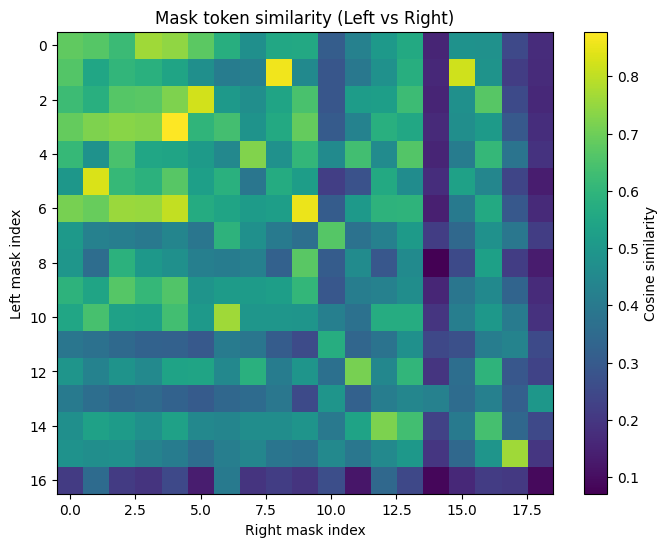

In [85]:
# plot heatmap of similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Cosine similarity')
plt.xlabel('Right mask index')
plt.ylabel('Left mask index')
plt.title('Mask token similarity (Left vs Right)')
plt.show()


## Ontology generation

In [86]:
# Re-run SAM segmentation + process_masks for both wings so we have
# embeddings AND valid_masks available for graph construction.

import cv2
import networkx as nx
from math import pi, sqrt

# --- Left wing ---
image1_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h.png"
image1_name = os.path.splitext(os.path.basename(image1_path))[0]
image1 = Image.open(image1_path).convert("RGB")
image1_np = np.array(image1)
predictor.set_image(image1_np)
masks_left_raw = mask_generator.generate(image1_np)
embeddings1, valid_masks1 = process_masks(image1_np, masks_left_raw, image1_name)

# --- Right wing ---
image2_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_R_cropped_rotated.png"
image2_name = os.path.splitext(os.path.basename(image2_path))[0]
image2 = Image.open(image2_path).convert("RGB")
image2_np = np.array(image2)
predictor.set_image(image2_np)
masks_right_raw = mask_generator.generate(image2_np)
embeddings2, valid_masks2 = process_masks(image2_np, masks_right_raw, image2_name)

print(f"\nLeft wing:  {len(valid_masks1)} segments, embeddings shape {embeddings1.shape}")
print(f"Right wing: {len(valid_masks2)} segments, embeddings shape {embeddings2.shape}")

Number of valid embeddings: 17
Embedding shape: (17, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h
Number of valid embeddings: 19
Embedding shape: (19, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_R_cropped_rotated

Left wing:  17 segments, embeddings shape (17, 1024)
Right wing: 19 segments, embeddings shape (19, 1024)


In [87]:
def compute_mask_features(mask_bool):
    """Compute geometric/shape features for a single boolean mask."""
    ys, xs = np.where(mask_bool)
    area = len(ys)
    centroid_x = xs.mean()
    centroid_y = ys.mean()

    # Contour-based features
    mask_u8 = mask_bool.astype(np.uint8)
    contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Use the largest contour
    contour = max(contours, key=cv2.contourArea) if contours else None

    perimeter = cv2.arcLength(contour, closed=True) if contour is not None else 0.0
    circularity = (4 * pi * area / (perimeter ** 2)) if perimeter > 0 else 0.0

    # Aspect ratio via fitEllipse (needs >= 5 points)
    if contour is not None and len(contour) >= 5:
        (_, _), (ma, MA), _ = cv2.fitEllipse(contour)
        aspect_ratio = (min(ma, MA) / max(ma, MA)) if max(ma, MA) > 0 else 1.0
    else:
        # Fallback: minAreaRect
        if contour is not None and len(contour) >= 1:
            _, (w, h), _ = cv2.minAreaRect(contour)
            aspect_ratio = (min(w, h) / max(w, h)) if max(w, h) > 0 else 1.0
        else:
            aspect_ratio = 1.0

    # Solidity: area / convex hull area
    if contour is not None and len(contour) >= 3:
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 1.0
    else:
        solidity = 1.0

    # Extent: area / bounding box area
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
    extent = area / bbox_area if bbox_area > 0 else 1.0

    equiv_diameter = sqrt(4 * area / pi)

    return {
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'aspect_ratio': aspect_ratio,
        'solidity': solidity,
        'extent': extent,
        'equiv_diameter': equiv_diameter,
    }


def extract_all_features(valid_masks, embeddings):
    """Extract features for all valid masks and attach embeddings."""
    features_list = []
    for i, mask in enumerate(valid_masks):
        mask_bool = mask['segmentation'].astype(bool)
        feats = compute_mask_features(mask_bool)
        feats['embedding'] = embeddings[i]
        feats['index'] = i
        features_list.append(feats)
    return features_list


features_left = extract_all_features(valid_masks1, embeddings1)
features_right = extract_all_features(valid_masks2, embeddings2)

# Summary table
print(f"{'Seg':>3}  {'Area':>7}  {'Perim':>7}  {'Circ':>5}  {'AR':>5}  {'Sol':>5}  {'Ext':>5}  {'EqD':>6}  {'Cx':>6}  {'Cy':>6}")
print("-" * 75)
for f in features_left:
    print(f"{f['index']:3d}  {f['area']:7d}  {f['perimeter']:7.1f}  {f['circularity']:.3f}  {f['aspect_ratio']:.3f}  {f['solidity']:.3f}  {f['extent']:.3f}  {f['equiv_diameter']:6.1f}  {f['centroid_x']:6.1f}  {f['centroid_y']:6.1f}")
print(f"\nLeft wing: {len(features_left)} segments")

print()
for f in features_right:
    print(f"{f['index']:3d}  {f['area']:7d}  {f['perimeter']:7.1f}  {f['circularity']:.3f}  {f['aspect_ratio']:.3f}  {f['solidity']:.3f}  {f['extent']:.3f}  {f['equiv_diameter']:6.1f}  {f['centroid_x']:6.1f}  {f['centroid_y']:6.1f}")
print(f"\nRight wing: {len(features_right)} segments")

Seg     Area    Perim   Circ     AR    Sol    Ext     EqD      Cx      Cy
---------------------------------------------------------------------------
  0    13560    499.9  0.682  0.535  0.959  0.728   131.4   435.3   186.7
  1    78215   1270.3  0.609  0.843  0.907  0.645   315.6   181.6   182.5
  2    14756    583.0  0.546  0.295  0.957  0.552   137.1   619.9   187.2
  3     9623    480.7  0.523  0.314  0.968  0.584   110.7   506.9    74.1
  4    15182    722.6  0.365  0.208  0.980  0.420   139.0   386.5   281.5
  5     9689    497.6  0.492  0.291  0.973  0.699   111.1   327.2    44.9
  6    12171    596.9  0.429  0.256  0.939  0.551   124.5   580.8   123.2
  7    45074   1434.5  0.275  0.777  0.901  0.465   239.6   633.4   305.0
  8     4932    349.6  0.507  0.230  0.990  0.541    79.2   805.4   141.4
  9     5586    327.5  0.655  0.440  0.975  0.598    84.3   373.7   118.4
 10    20480    818.6  0.384  0.304  0.958  0.598   161.5   787.1    71.8
 11     8274    560.6  0.331  0.408 

In [88]:
def bbox_overlap_area(bbox_i, bbox_j):
    """Compute overlap area between two XYWH bboxes."""
    x1, y1, w1, h1 = bbox_i
    x2, y2, w2, h2 = bbox_j
    xi_min, xi_max = x1, x1 + w1
    yi_min, yi_max = y1, y1 + h1
    xj_min, xj_max = x2, x2 + w2
    yj_min, yj_max = y2, y2 + h2
    inter_x = max(0, min(xi_max, xj_max) - max(xi_min, xj_min))
    inter_y = max(0, min(yi_max, yj_max) - max(yi_min, yj_min))
    return inter_x * inter_y


def compute_adjacency(valid_masks, features_list, max_gap=15,
                      containment_threshold=0.15, bbox_pad=None):
    """Detect adjacency via three-stage filtering.

    Stage 1 – Expanded bbox overlap (fast pre-filter):
        Skip pairs whose padded bboxes don't overlap at all.

    Stage 2 – Containment rejection:
        If the pixel overlap between two masks exceeds `containment_threshold`
        of the smaller mask's area, they are nested (e.g. a cell inside the
        whole wing), not adjacent.  Skip them.

    Stage 3 – Minimum mask boundary gap (the real filter):
        For surviving non-overlapping pairs, compute the minimum pixel distance
        between the two mask boundaries via cv2.distanceTransform.
        Only create an edge if gap <= max_gap.

    Connection strength = 1 - (min_gap / max_gap).

    Parameters
    ----------
    max_gap : float
        Max gap in pixels between mask boundaries to count as neighbors.
    containment_threshold : float
        If mask overlap / smaller mask area > this, skip as containment.
    bbox_pad : float or None
        Padding for bbox pre-filter. Defaults to max_gap.
    """
    if bbox_pad is None:
        bbox_pad = max_gap

    n = len(valid_masks)
    bboxes = [m['bbox'] for m in valid_masks]
    bool_masks = [m['segmentation'].astype(np.uint8) for m in valid_masks]
    areas = [int(m.sum()) for m in bool_masks]

    # Pre-compute distance transforms
    dist_transforms = []
    for m in bool_masks:
        inv = 1 - m
        dt = cv2.distanceTransform(inv, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        dist_transforms.append(dt)

    edges = []
    skipped_containment = 0
    skipped_gap = 0
    for i in range(n):
        for j in range(i + 1, n):
            # --- Stage 1: expanded bbox pre-filter ---
            bx_i = (bboxes[i][0] - bbox_pad, bboxes[i][1] - bbox_pad,
                     bboxes[i][2] + 2 * bbox_pad, bboxes[i][3] + 2 * bbox_pad)
            bx_j = (bboxes[j][0] - bbox_pad, bboxes[j][1] - bbox_pad,
                     bboxes[j][2] + 2 * bbox_pad, bboxes[j][3] + 2 * bbox_pad)
            if bbox_overlap_area(bx_i, bx_j) == 0:
                continue

            # --- Stage 2: containment rejection ---
            mask_overlap = int(np.logical_and(bool_masks[i], bool_masks[j]).sum())
            smaller_area = min(areas[i], areas[j])
            if smaller_area > 0 and mask_overlap / smaller_area > containment_threshold:
                skipped_containment += 1
                continue

            # --- Stage 3: minimum mask gap distance ---
            gap_j_to_i = dist_transforms[i][bool_masks[j] > 0]
            gap_i_to_j = dist_transforms[j][bool_masks[i] > 0]

            if gap_j_to_i.size == 0 or gap_i_to_j.size == 0:
                continue

            min_gap = min(float(gap_j_to_i.min()), float(gap_i_to_j.min()))

            if min_gap > max_gap:
                skipped_gap += 1
                continue

            connection_strength = 1.0 - (min_gap / max_gap)

            # Diagnostics
            bbox_overlap = bbox_overlap_area(bboxes[i], bboxes[j])
            bbox_area_i = bboxes[i][2] * bboxes[i][3]
            bbox_area_j = bboxes[j][2] * bboxes[j][3]
            min_bbox_area = min(bbox_area_i, bbox_area_j)
            bbox_overlap_ratio = bbox_overlap / min_bbox_area if min_bbox_area > 0 else 0.0

            cx_i, cy_i = features_list[i]['centroid_x'], features_list[i]['centroid_y']
            cx_j, cy_j = features_list[j]['centroid_x'], features_list[j]['centroid_y']
            centroid_dist = sqrt((cx_i - cx_j) ** 2 + (cy_i - cy_j) ** 2)

            edges.append((i, j, {
                'min_gap': min_gap,
                'mask_overlap_ratio': mask_overlap / smaller_area if smaller_area > 0 else 0.0,
                'bbox_overlap': bbox_overlap,
                'bbox_overlap_ratio': bbox_overlap_ratio,
                'connection_strength': connection_strength,
                'centroid_distance': centroid_dist,
            }))

    print(f"  Skipped {skipped_containment} pairs (containment), "
          f"{skipped_gap} pairs (gap > {max_gap}px)")
    return edges


edges_left = compute_adjacency(valid_masks1, features_left)
edges_right = compute_adjacency(valid_masks2, features_right)

print(f"\nLeft wing:  {len(edges_left)} edges among {len(valid_masks1)} segments")
print(f"Right wing: {len(edges_right)} edges among {len(valid_masks2)} segments")
print(f"\nLeft wing edges (sorted by gap):")
for e in sorted(edges_left, key=lambda e: e[2]['min_gap']):
    i, j, w = e
    print(f"  {i:2d}-{j:2d}: gap={w['min_gap']:5.1f}px, strength={w['connection_strength']:.3f}, "
          f"mask_ovlp={w['mask_overlap_ratio']:.2f}, centroid_dist={w['centroid_distance']:.0f}")
print(f"\nRight wing edges (sorted by gap):")
for e in sorted(edges_right, key=lambda e: e[2]['min_gap']):
    i, j, w = e
    print(f"  {i:2d}-{j:2d}: gap={w['min_gap']:5.1f}px, strength={w['connection_strength']:.3f}, "
          f"mask_ovlp={w['mask_overlap_ratio']:.2f}, centroid_dist={w['centroid_distance']:.0f}")

  Skipped 1 pairs (containment), 18 pairs (gap > 15px)
  Skipped 7 pairs (containment), 26 pairs (gap > 15px)

Left wing:  32 edges among 17 segments
Right wing: 41 edges among 19 segments

Left wing edges (sorted by gap):
   1-11: gap=  0.0px, strength=1.000, mask_ovlp=0.00, centroid_dist=166
  14-16: gap=  1.0px, strength=0.933, mask_ovlp=0.00, centroid_dist=161
   4- 7: gap=  1.4px, strength=0.906, mask_ovlp=0.00, centroid_dist=248
   5-14: gap=  1.4px, strength=0.906, mask_ovlp=0.00, centroid_dist=127
   7-12: gap=  1.4px, strength=0.906, mask_ovlp=0.00, centroid_dist=124
   2-12: gap=  2.0px, strength=0.867, mask_ovlp=0.00, centroid_dist=104
   3-14: gap=  2.0px, strength=0.867, mask_ovlp=0.00, centroid_dist=73
   7-13: gap=  2.0px, strength=0.867, mask_ovlp=0.00, centroid_dist=289
   8-13: gap=  2.0px, strength=0.867, mask_ovlp=0.00, centroid_dist=135
  12-13: gap=  2.0px, strength=0.867, mask_ovlp=0.00, centroid_dist=192
   1- 4: gap=  2.2px, strength=0.851, mask_ovlp=0.00, cent

In [89]:
def build_wing_graph(features_list, edges, name="wing"):
    """Build a networkx graph from features and adjacency edges."""
    G = nx.Graph(name=name)
    for f in features_list:
        attrs = {k: v for k, v in f.items() if k != 'embedding'}
        attrs['embedding'] = f['embedding']  # stored but excluded from printing
        G.add_node(f['index'], **attrs)
    for i, j, w in edges:
        G.add_edge(i, j, **w)

    # Summary
    degrees = [d for _, d in G.degree()]
    components = nx.number_connected_components(G)
    isolated = list(nx.isolates(G))
    print(f"--- {name} ---")
    print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"  Density: {nx.density(G):.4f}")
    print(f"  Connected components: {components}")
    print(f"  Degree range: {min(degrees)}-{max(degrees)}, mean {np.mean(degrees):.1f}")
    if isolated:
        print(f"  Isolated nodes: {isolated}")
    return G


G_left = build_wing_graph(features_left, edges_left, name="Left wing")
print()
G_right = build_wing_graph(features_right, edges_right, name="Right wing")

--- Left wing ---
  Nodes: 17, Edges: 32
  Density: 0.2353
  Connected components: 2
  Degree range: 0-7, mean 3.8
  Isolated nodes: [15]

--- Right wing ---
  Nodes: 19, Edges: 41
  Density: 0.2398
  Connected components: 2
  Degree range: 0-7, mean 4.3
  Isolated nodes: [17]


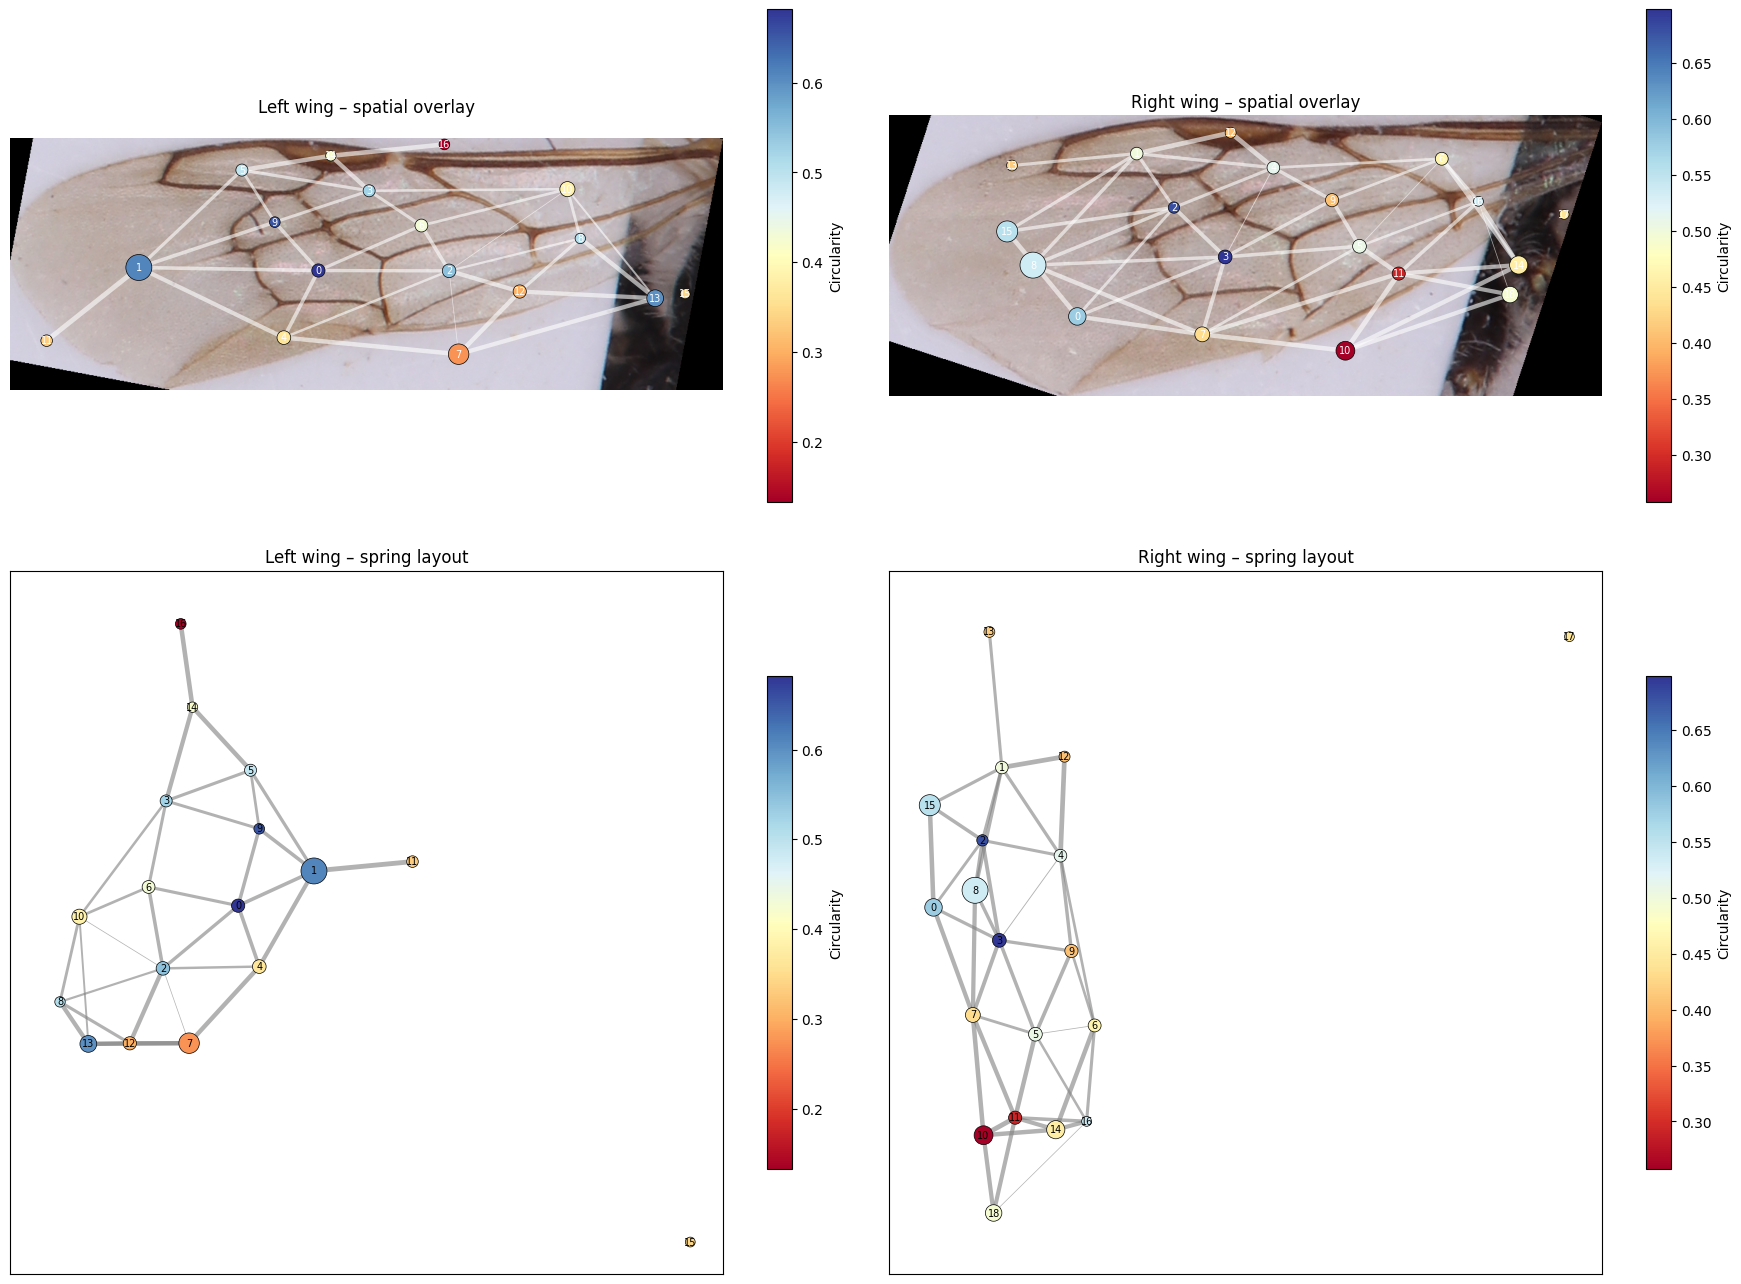

In [90]:
def draw_wing_graph(G, image_np, ax, title, use_spatial=True):
    """Draw a wing graph either on top of the image (spatial) or spring layout."""
    if use_spatial:
        pos = {n: (G.nodes[n]['centroid_x'], G.nodes[n]['centroid_y']) for n in G.nodes}
        ax.imshow(image_np)
    else:
        pos = nx.spring_layout(G, seed=42, weight='connection_strength')

    areas = np.array([G.nodes[n]['area'] for n in G.nodes])
    circs = np.array([G.nodes[n]['circularity'] for n in G.nodes])
    # Node size proportional to area (scaled for visibility)
    node_sizes = 50 + 300 * (areas - areas.min()) / (areas.max() - areas.min() + 1e-9)

    # Edge widths proportional to connection strength
    if G.number_of_edges() > 0:
        strengths = np.array([G.edges[e]['connection_strength'] for e in G.edges])
        edge_widths = 0.5 + 3.0 * (strengths - strengths.min()) / (strengths.max() - strengths.min() + 1e-9)
    else:
        edge_widths = []

    nx.draw_networkx_edges(G, pos, ax=ax, width=list(edge_widths),
                           alpha=0.6, edge_color='white' if use_spatial else 'gray')
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes,
                                   node_color=circs, cmap=plt.cm.RdYlBu,
                                   edgecolors='black', linewidths=0.5)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=7,
                            font_color='white' if use_spatial else 'black')
    plt.colorbar(nodes, ax=ax, label='Circularity', shrink=0.7)
    ax.set_title(title)
    ax.axis('off' if use_spatial else 'on')


fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Row 1: Spatial overlays
draw_wing_graph(G_left, image1_np, axes[0, 0], "Left wing – spatial overlay", use_spatial=True)
draw_wing_graph(G_right, image2_np, axes[0, 1], "Right wing – spatial overlay", use_spatial=True)

# Row 2: Spring layouts
draw_wing_graph(G_left, image1_np, axes[1, 0], "Left wing – spring layout", use_spatial=False)
draw_wing_graph(G_right, image2_np, axes[1, 1], "Right wing – spring layout", use_spatial=False)

plt.tight_layout()
plt.show()

In [91]:
from sklearn.metrics.pairwise import cosine_similarity


def compare_wing_graphs(G_left, G_right, embeddings1, embeddings2):
    """Compare two wing graphs structurally and via embeddings."""
    results = {}

    # --- 1. Structural stats ---
    def graph_stats(G):
        degrees = [d for _, d in G.degree()]
        stats = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'avg_degree': np.mean(degrees),
            'clustering_coeff': nx.average_clustering(G),
        }
        if nx.is_connected(G):
            stats['diameter'] = nx.diameter(G)
            stats['avg_path_length'] = nx.average_shortest_path_length(G)
        else:
            # Use largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            sub = G.subgraph(largest_cc)
            stats['diameter'] = nx.diameter(sub)
            stats['avg_path_length'] = nx.average_shortest_path_length(sub)
        return stats

    stats_L = graph_stats(G_left)
    stats_R = graph_stats(G_right)
    results['stats_left'] = stats_L
    results['stats_right'] = stats_R

    print("=== Structural Statistics ===")
    print(f"{'Metric':<22} {'Left':>10} {'Right':>10}")
    print("-" * 44)
    for key in stats_L:
        vl = stats_L[key]
        vr = stats_R[key]
        fmt = f"{vl:10.4f}" if isinstance(vl, float) else f"{vl:10d}"
        fmr = f"{vr:10.4f}" if isinstance(vr, float) else f"{vr:10d}"
        print(f"{key:<22} {fmt} {fmr}")

    # --- 2. Degree distribution L1 distance ---
    max_deg = max(max(d for _, d in G_left.degree()), max(d for _, d in G_right.degree()))
    hist_L = np.zeros(max_deg + 1)
    hist_R = np.zeros(max_deg + 1)
    for _, d in G_left.degree():
        hist_L[d] += 1
    for _, d in G_right.degree():
        hist_R[d] += 1
    hist_L /= hist_L.sum()
    hist_R /= hist_R.sum()
    degree_l1 = np.sum(np.abs(hist_L - hist_R))
    results['degree_l1'] = degree_l1
    print(f"\nDegree distribution L1 distance: {degree_l1:.4f}")

    # --- 3. Spectral similarity ---
    eig_L = np.sort(nx.laplacian_spectrum(G_left))
    eig_R = np.sort(nx.laplacian_spectrum(G_right))
    # Zero-pad to same length
    max_len = max(len(eig_L), len(eig_R))
    eig_L_pad = np.zeros(max_len); eig_L_pad[:len(eig_L)] = eig_L
    eig_R_pad = np.zeros(max_len); eig_R_pad[:len(eig_R)] = eig_R
    spectral_l2 = np.linalg.norm(eig_L_pad - eig_R_pad)
    max_norm = max(np.linalg.norm(eig_L_pad), np.linalg.norm(eig_R_pad))
    spectral_sim = 1.0 - spectral_l2 / max_norm if max_norm > 0 else 1.0
    results['spectral_l2'] = spectral_l2
    results['spectral_similarity'] = spectral_sim
    results['eig_L'] = eig_L
    results['eig_R'] = eig_R
    print(f"Spectral L2 distance: {spectral_l2:.4f}")
    print(f"Spectral similarity:  {spectral_sim:.4f}")

    # --- 4. Node matching via DINOv2 cosine similarity (greedy) ---
    sim_matrix = cosine_similarity(embeddings1, embeddings2)
    n_left, n_right = sim_matrix.shape
    # Flatten and sort in descending order
    flat_idx = np.argsort(sim_matrix.ravel())[::-1]
    used_left = set()
    used_right = set()
    matches = []  # (left_idx, right_idx, similarity)
    for idx in flat_idx:
        li = idx // n_right
        ri = idx % n_right
        if li in used_left or ri in used_right:
            continue
        matches.append((int(li), int(ri), float(sim_matrix[li, ri])))
        used_left.add(li)
        used_right.add(ri)
        if len(matches) == min(n_left, n_right):
            break
    results['node_matches'] = matches
    match_sims = [s for _, _, s in matches]
    print(f"\nNode matching (greedy DINOv2): {len(matches)} pairs")
    print(f"  Mean similarity: {np.mean(match_sims):.4f}")
    print(f"  Min:  {np.min(match_sims):.4f}, Max: {np.max(match_sims):.4f}")

    # --- 5. Edge agreement ---
    match_map = {li: ri for li, ri, _ in matches}
    left_edges_mapped = 0
    left_edges_preserved = 0
    for u, v in G_left.edges():
        if u in match_map and v in match_map:
            left_edges_mapped += 1
            mu, mv = match_map[u], match_map[v]
            if G_right.has_edge(mu, mv):
                left_edges_preserved += 1
    edge_agreement = left_edges_preserved / left_edges_mapped if left_edges_mapped > 0 else 0.0
    results['edge_agreement'] = edge_agreement
    results['edges_mapped'] = left_edges_mapped
    results['edges_preserved'] = left_edges_preserved
    print(f"\nEdge agreement: {left_edges_preserved}/{left_edges_mapped} = {edge_agreement:.4f}")

    # --- 6. Feature distribution comparison ---
    shape_keys = ['area', 'perimeter', 'circularity', 'aspect_ratio', 'solidity', 'extent', 'equiv_diameter']
    print(f"\n{'Feature':<18} {'Left mean':>10} {'Right mean':>10} {'Diff':>10}")
    print("-" * 50)
    feat_comparison = {}
    for key in shape_keys:
        vals_L = np.array([G_left.nodes[n][key] for n in G_left.nodes])
        vals_R = np.array([G_right.nodes[n][key] for n in G_right.nodes])
        ml, mr = vals_L.mean(), vals_R.mean()
        feat_comparison[key] = {'left_mean': ml, 'right_mean': mr, 'diff': abs(ml - mr)}
        print(f"{key:<18} {ml:10.2f} {mr:10.2f} {abs(ml - mr):10.2f}")
    results['feature_comparison'] = feat_comparison
    results['hist_L'] = hist_L
    results['hist_R'] = hist_R

    return results


comparison = compare_wing_graphs(G_left, G_right, embeddings1, embeddings2)

=== Structural Statistics ===
Metric                       Left      Right
--------------------------------------------
nodes                          17         19
edges                          32         41
density                    0.2353     0.2398
avg_degree                 3.7647     4.3158
clustering_coeff           0.3765     0.4499
diameter                        5          5
avg_path_length            2.2500     2.1765

Degree distribution L1 distance: 0.8297
Spectral L2 distance: 11.9986
Spectral similarity:  0.4634

Node matching (greedy DINOv2): 17 pairs
  Mean similarity: 0.6899
  Min:  0.2096, Max: 0.8778

Edge agreement: 28/32 = 0.8750

Feature             Left mean Right mean       Diff
--------------------------------------------------
area                 17190.24   18726.74    1536.50
perimeter              653.59     641.36      12.23
circularity              0.45       0.48       0.04
aspect_ratio             0.35       0.33       0.02
solidity                 0

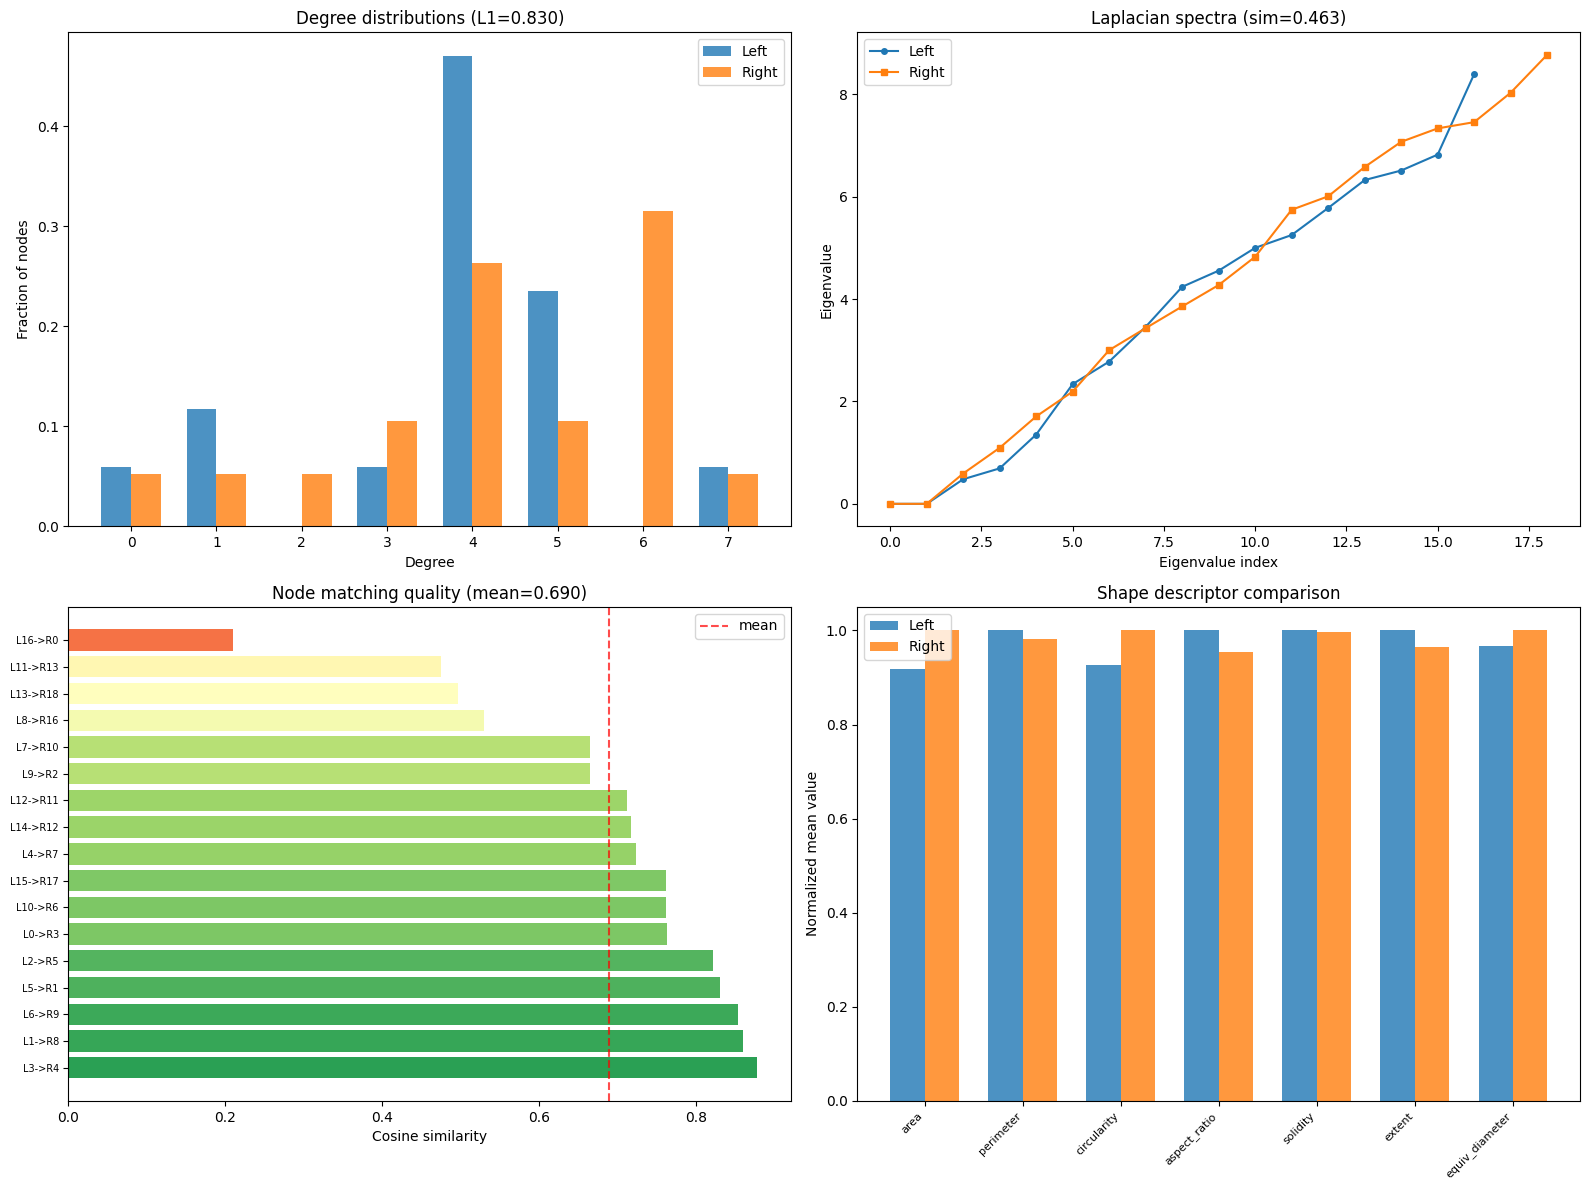

In [92]:
def plot_comparison(comparison):
    """Visualize graph comparison results."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # --- 1. Degree distributions ---
    ax = axes[0, 0]
    x = np.arange(len(comparison['hist_L']))
    w = 0.35
    ax.bar(x - w/2, comparison['hist_L'], w, label='Left', alpha=0.8)
    ax.bar(x + w/2, comparison['hist_R'], w, label='Right', alpha=0.8)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Fraction of nodes')
    ax.set_title(f"Degree distributions (L1={comparison['degree_l1']:.3f})")
    ax.legend()

    # --- 2. Laplacian spectra ---
    ax = axes[0, 1]
    ax.plot(comparison['eig_L'], 'o-', label='Left', markersize=4)
    ax.plot(comparison['eig_R'], 's-', label='Right', markersize=4)
    ax.set_xlabel('Eigenvalue index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f"Laplacian spectra (sim={comparison['spectral_similarity']:.3f})")
    ax.legend()

    # --- 3. Node match quality ---
    ax = axes[1, 0]
    matches = comparison['node_matches']
    labels = [f"L{li}->R{ri}" for li, ri, _ in matches]
    sims = [s for _, _, s in matches]
    colors = plt.cm.RdYlGn([s for s in sims])
    ax.barh(range(len(matches)), sims, color=colors)
    ax.set_yticks(range(len(matches)))
    ax.set_yticklabels(labels, fontsize=7)
    ax.set_xlabel('Cosine similarity')
    ax.set_title(f"Node matching quality (mean={np.mean(sims):.3f})")
    ax.axvline(x=np.mean(sims), color='red', linestyle='--', alpha=0.7, label='mean')
    ax.legend()

    # --- 4. Mean shape descriptors ---
    ax = axes[1, 1]
    fc = comparison['feature_comparison']
    keys = list(fc.keys())
    left_vals = [fc[k]['left_mean'] for k in keys]
    right_vals = [fc[k]['right_mean'] for k in keys]
    # Normalize for comparison
    max_vals = [max(abs(l), abs(r), 1e-9) for l, r in zip(left_vals, right_vals)]
    left_norm = [l / m for l, m in zip(left_vals, max_vals)]
    right_norm = [r / m for r, m in zip(right_vals, max_vals)]
    x = np.arange(len(keys))
    ax.bar(x - w/2, left_norm, w, label='Left', alpha=0.8)
    ax.bar(x + w/2, right_norm, w, label='Right', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Normalized mean value')
    ax.set_title('Shape descriptor comparison')
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_comparison(comparison)

# Ontology Decision Pipeline

Given two graphs A and B with **no labels**, this pipeline determines whether they share a common ontology (structural blueprint) through four progressively rigorous stages.

## How it works

Each graph represents a segmented object (e.g. a bee wing) where **nodes** are segments (wing cells) with features (area, shape, DINOv2 embedding) and **edges** encode physical adjacency between segments.

The pipeline asks: *"Is the structural similarity between A and B statistically meaningful, or could it arise by chance?"*

---

### Step 1 — Coarse Filter (cheap global rejection)
Compares high-level graph statistics to catch obviously different structures early:
- **Node ratio**: `max(|A|, |B|) / min(|A|, |B|)`. If one graph has 3x more nodes, they probably aren't the same thing. Threshold: < 2.5.
- **Degree distribution L1**: Histogram of how many neighbors each node has, compared via L1 distance. Measures whether the connectivity pattern is similar. Range: 0 (identical) to 2 (completely different). Threshold: < 1.5.
- **Density ratio**: Graph density = edges / possible edges. Compares how "connected" each graph is. Threshold: < 3.0.

*If any threshold is exceeded → REJECT immediately (no further computation).*

### Step 2 — Multi-Modal Matching (are the matches consistent?)
Independently matches nodes of A to nodes of B using four different feature modalities, each via the **Hungarian algorithm** (globally optimal 1:1 assignment):

| Modality | What it uses | Cost metric |
|----------|-------------|-------------|
| **Appearance** | DINOv2 embeddings (1024-d) | 1 − cosine similarity |
| **Shape** | Area, perimeter, circularity, aspect ratio, solidity, extent, equiv. diameter | Euclidean distance (standardized) |
| **Topology** | Degree, clustering coefficient, betweenness centrality | Euclidean distance (standardized) |
| **Spatial** | Centroid positions (normalized to [0,1]) | Euclidean distance |

Then measures **pairwise agreement**: for each pair of modalities, what fraction of nodes got matched to the same partner? High agreement means the correspondence is real (multiple independent signals converge). Low agreement means the matches are coincidental.

- **Mean agreement** across all 6 modality pairs is reported. Threshold: > 0.25 for "high consensus".

### Step 3 — Permutation Test (is edge agreement significant?)
Uses the appearance-based matching (typically strongest) and computes **edge agreement**: the fraction of edges in graph A that also exist in graph B under the node matching.

To determine if this is meaningful, runs **1000 random permutations** — randomly assigning A's nodes to B's nodes — and computes edge agreement for each. This builds a **null distribution** of "what edge agreement looks like by chance."

- **z-score**: How many standard deviations the real score is above the null mean. z > 2 is unusual, z > 4 is very strong.
- **p-value**: Fraction of random permutations that scored ≥ the real score. p < 0.05 means the structural correspondence is statistically significant at 95% confidence.

*This is the most important test. It directly answers: "Could this match happen by accident?"*

### Step 4 — Stable Core Extraction (which parts are reliably shared?)
Repeatedly **perturbs** graph A (drops a random node, 500 times) and re-runs Hungarian matching each time. A node pair that survives consistently across perturbations is a **stable match** — its correspondence is robust, not dependent on any single other node.

- **Stability** (per pair): fraction of perturbations where this pair was matched. 1.0 = always matched the same way.
- **Stable core**: all pairs with stability ≥ 0.80. These form the **discovered shared ontology**.
- **Core edges**: edges in A whose both endpoints have stable partners AND the corresponding edge exists in B. This is the shared "wiring diagram."
- **Coverage**: fraction of nodes included in the stable core. High coverage = most of the structure is shared.

---

## Final Decision

The pipeline outputs **SHARED** or **DIFFERENT** based on three conditions:
- `significant`: p-value < 0.05 (required)
- `high_consensus`: mean modality agreement > 0.25
- `large_core`: stable core coverage > 50%

Decision rule: `significant AND (high_consensus OR large_core)`

## Confidence Score

The confidence score (0 to 1) is the average of three independent signals:

| Signal | What it measures | Range |
|--------|-----------------|-------|
| `1 − p_value` | Statistical significance of edge agreement vs chance | 0 = indistinguishable from random, 1 = no random permutation matched it |
| `mean_agreement` | Cross-modality matching consensus | 0 = modalities disagree completely, 1 = all four modalities give identical matches |
| `core_coverage` | Fraction of nodes in the stable core | 0 = no stable matches, 1 = every node has a robust partner |

A confidence of 0.77 means: the permutation test is decisive (≈1.0), modality consensus is moderate (≈0.36), and almost all nodes are stably matched (≈0.94).

In [93]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler


# ---------------------------------------------------------------------------
# STEP 1: Coarse filter
# ---------------------------------------------------------------------------
def coarse_filter(G_A, G_B, max_node_ratio=2.5, max_degree_l1=1.5,
                  max_density_ratio=3.0):
    """Fast rejection based on global graph statistics."""
    n_A, n_B = G_A.number_of_nodes(), G_B.number_of_nodes()
    d_A, d_B = nx.density(G_A), nx.density(G_B)

    node_ratio = max(n_A, n_B) / max(min(n_A, n_B), 1)
    density_ratio = max(d_A, d_B) / max(min(d_A, d_B), 1e-9)

    # Degree distribution L1
    max_deg = max(
        max((d for _, d in G_A.degree()), default=0),
        max((d for _, d in G_B.degree()), default=0),
    )
    hist_A = np.zeros(max_deg + 1)
    hist_B = np.zeros(max_deg + 1)
    for _, d in G_A.degree():
        hist_A[d] += 1
    for _, d in G_B.degree():
        hist_B[d] += 1
    hist_A /= max(hist_A.sum(), 1)
    hist_B /= max(hist_B.sum(), 1)
    degree_l1 = float(np.sum(np.abs(hist_A - hist_B)))

    passed = (node_ratio < max_node_ratio
              and degree_l1 < max_degree_l1
              and density_ratio < max_density_ratio)

    info = dict(passed=passed, node_ratio=node_ratio, degree_l1=degree_l1,
                density_ratio=density_ratio,
                stats_A=dict(nodes=n_A, edges=G_A.number_of_edges(), density=d_A),
                stats_B=dict(nodes=n_B, edges=G_B.number_of_edges(), density=d_B))
    return passed, info


# ---------------------------------------------------------------------------
# STEP 2: Multi-modal Hungarian matching
# ---------------------------------------------------------------------------
def _hungarian(cost):
    """Run Hungarian on a (possibly rectangular) cost matrix."""
    ri, ci = linear_sum_assignment(cost)
    return dict(zip(ri.tolist(), ci.tolist()))


def multimodal_matching(G_A, G_B, emb_A, emb_B):
    """Match nodes using four independent modalities. Return matchings and
    pairwise agreement matrix."""
    nodes_A = sorted(G_A.nodes())
    nodes_B = sorted(G_B.nodes())
    matchings = {}

    # --- Appearance (DINOv2 cosine similarity) ---
    sim = cosine_similarity(emb_A, emb_B)
    matchings['appearance'] = _hungarian(1.0 - sim)

    # --- Shape descriptors (Euclidean on standardized features) ---
    shape_keys = ['area', 'perimeter', 'circularity', 'aspect_ratio',
                  'solidity', 'extent', 'equiv_diameter']
    fA = np.array([[G_A.nodes[n][k] for k in shape_keys] for n in nodes_A])
    fB = np.array([[G_B.nodes[n][k] for k in shape_keys] for n in nodes_B])
    stacked = np.vstack([fA, fB])
    normed = StandardScaler().fit_transform(stacked)
    matchings['shape'] = _hungarian(cdist(normed[:len(nodes_A)],
                                          normed[len(nodes_A):]))

    # --- Topology (degree, clustering coeff, betweenness centrality) ---
    def _topo(G, nodes):
        cc = nx.clustering(G)
        bc = nx.betweenness_centrality(G)
        return np.array([[G.degree(n), cc[n], bc[n]] for n in nodes])
    tA, tB = _topo(G_A, nodes_A), _topo(G_B, nodes_B)
    stacked = np.vstack([tA, tB])
    normed = StandardScaler().fit_transform(stacked)
    matchings['topology'] = _hungarian(cdist(normed[:len(nodes_A)],
                                              normed[len(nodes_A):]))

    # --- Spatial (normalized centroids) ---
    def _spatial(G, nodes):
        cx = np.array([G.nodes[n]['centroid_x'] for n in nodes])
        cy = np.array([G.nodes[n]['centroid_y'] for n in nodes])
        cx = (cx - cx.min()) / (cx.max() - cx.min() + 1e-9)
        cy = (cy - cy.min()) / (cy.max() - cy.min() + 1e-9)
        return np.column_stack([cx, cy])
    matchings['spatial'] = _hungarian(cdist(_spatial(G_A, nodes_A),
                                             _spatial(G_B, nodes_B)))

    # --- Pairwise agreement ---
    names = list(matchings.keys())
    k = len(names)
    agree = np.eye(k)
    for mi in range(k):
        for mj in range(mi + 1, k):
            m1, m2 = matchings[names[mi]], matchings[names[mj]]
            common = set(m1) & set(m2)
            if common:
                frac = sum(1 for c in common if m1[c] == m2[c]) / len(common)
            else:
                frac = 0.0
            agree[mi, mj] = agree[mj, mi] = frac

    mask = ~np.eye(k, dtype=bool)
    mean_agree = float(agree[mask].mean())

    return matchings, agree, names, mean_agree


# ---------------------------------------------------------------------------
# STEP 3: Permutation test for edge agreement
# ---------------------------------------------------------------------------
def _edge_agreement(G_A, G_B, matching):
    mapped = preserved = 0
    for u, v in G_A.edges():
        if u in matching and v in matching:
            mapped += 1
            if G_B.has_edge(matching[u], matching[v]):
                preserved += 1
    return preserved / mapped if mapped > 0 else 0.0


def permutation_test(G_A, G_B, real_matching, n_perms=1000):
    """Compare real edge agreement to a null distribution of random matchings."""
    nodes_A = sorted(G_A.nodes())
    nodes_B = sorted(G_B.nodes())
    n_match = min(len(nodes_A), len(nodes_B))

    real_ea = _edge_agreement(G_A, G_B, real_matching)

    null = np.empty(n_perms)
    for t in range(n_perms):
        perm = np.random.permutation(len(nodes_B))[:n_match]
        rand_match = {nodes_A[i]: nodes_B[perm[i]] for i in range(n_match)}
        null[t] = _edge_agreement(G_A, G_B, rand_match)

    p_value = float(np.mean(null >= real_ea))
    z_score = float((real_ea - null.mean()) / (null.std() + 1e-9))

    return dict(real_agreement=real_ea, null_mean=float(null.mean()),
                null_std=float(null.std()), p_value=p_value,
                z_score=z_score, null_distribution=null)


# ---------------------------------------------------------------------------
# STEP 4: Stable core extraction
# ---------------------------------------------------------------------------
def stable_core(G_A, G_B, emb_A, emb_B, n_perturbations=500,
                stability_threshold=0.80):
    """Repeatedly drop a random node from A, re-match via Hungarian,
    and keep only pairs that survive in >= stability_threshold fraction
    of perturbations."""
    nodes_A = sorted(G_A.nodes())
    nodes_B = sorted(G_B.nodes())
    nA = len(nodes_A)

    pair_counts = {}
    node_seen = {n: 0 for n in nodes_A}

    for _ in range(n_perturbations):
        drop = np.random.randint(nA)
        remaining = [i for i in range(nA) if i != drop]
        emb_sub = emb_A[remaining]
        sim_sub = cosine_similarity(emb_sub, emb_B)
        ri, ci = linear_sum_assignment(1.0 - sim_sub)
        for r, c in zip(ri, ci):
            a_node = nodes_A[remaining[r]]
            b_node = nodes_B[c]
            pair_counts[(a_node, b_node)] = pair_counts.get((a_node, b_node), 0) + 1
            node_seen[a_node] = node_seen.get(a_node, 0) + 1

    # Compute stability as fraction of times this node participated
    # that it was matched to this particular partner
    stable_pairs = []
    for (a, b), cnt in pair_counts.items():
        participation = node_seen.get(a, 1)
        stab = cnt / participation
        if stab >= stability_threshold:
            a_idx = nodes_A.index(a)
            b_idx = nodes_B.index(b)
            sim = float(cosine_similarity(emb_A[a_idx:a_idx+1],
                                          emb_B[b_idx:b_idx+1])[0, 0])
            stable_pairs.append(dict(node_A=a, node_B=b, stability=stab,
                                     similarity=sim))

    stable_pairs.sort(key=lambda x: -x['stability'])

    # Core edges: edges in A whose both endpoints have stable partners
    # AND the corresponding edge exists in B
    stable_map = {p['node_A']: p['node_B'] for p in stable_pairs}
    core_edges = []
    for u, v in G_A.edges():
        if u in stable_map and v in stable_map:
            mu, mv = stable_map[u], stable_map[v]
            if G_B.has_edge(mu, mv):
                core_edges.append((u, v, mu, mv))

    n_min = min(nA, len(nodes_B))
    return dict(pairs=stable_pairs, n_stable=len(stable_pairs),
                coverage=len(stable_pairs) / n_min if n_min > 0 else 0,
                core_edges=core_edges, stable_matching=stable_map)


# ---------------------------------------------------------------------------
# FULL PIPELINE
# ---------------------------------------------------------------------------
def ontology_decision_pipeline(G_A, G_B, emb_A, emb_B,
                               n_perms=1000, n_perturbations=500,
                               alpha=0.05):
    """Run the full 4-step decision pipeline.

    Returns a results dict with:
      decision        : 'SHARED' or 'DIFFERENT'
      confidence      : float in [0, 1]
      coarse          : Step 1 output
      matching        : Step 2 output
      permutation     : Step 3 output
      core            : Step 4 output
    """
    results = {}

    # Step 1
    passed, coarse_info = coarse_filter(G_A, G_B)
    results['coarse'] = coarse_info
    print(f"STEP 1  Coarse filter: {'PASS' if passed else 'REJECT'}")
    print(f"        node ratio={coarse_info['node_ratio']:.2f}, "
          f"degree L1={coarse_info['degree_l1']:.3f}, "
          f"density ratio={coarse_info['density_ratio']:.2f}")
    if not passed:
        results['decision'] = 'DIFFERENT'
        results['confidence'] = 1.0
        return results

    # Step 2
    matchings, agree_mat, mod_names, mean_agree = multimodal_matching(
        G_A, G_B, emb_A, emb_B)
    results['matching'] = dict(matchings=matchings, agreement_matrix=agree_mat,
                               modality_names=mod_names,
                               mean_agreement=mean_agree)
    print(f"\nSTEP 2  Multi-modal matching consensus: {mean_agree:.3f}")
    for mi, m1 in enumerate(mod_names):
        row = "        " + f"{m1:>12s}: "
        row += "  ".join(f"{agree_mat[mi, mj]:.2f}" for mj in range(len(mod_names)))
        print(row)

    # Step 3 — use appearance matching as primary
    primary = matchings['appearance']
    perm = permutation_test(G_A, G_B, primary, n_perms=n_perms)
    results['permutation'] = perm
    print(f"\nSTEP 3  Permutation test:")
    print(f"        real edge agreement = {perm['real_agreement']:.4f}")
    print(f"        null mean ± std     = {perm['null_mean']:.4f} ± {perm['null_std']:.4f}")
    print(f"        z-score = {perm['z_score']:.2f},  p-value = {perm['p_value']:.4f}")

    # Step 4
    core = stable_core(G_A, G_B, emb_A, emb_B, n_perturbations=n_perturbations)
    results['core'] = core
    print(f"\nSTEP 4  Stable core:")
    print(f"        {core['n_stable']} stable pairs "
          f"(coverage = {core['coverage']:.1%})")
    print(f"        {len(core['core_edges'])} core edges preserved in both graphs")
    for p in core['pairs']:
        print(f"          A:{p['node_A']:2d} <-> B:{p['node_B']:2d}  "
              f"stability={p['stability']:.2f}  sim={p['similarity']:.3f}")

    # --- Final decision ---
    significant = perm['p_value'] < alpha
    high_consensus = mean_agree > 0.25
    large_core = core['coverage'] > 0.5

    shared = significant and (high_consensus or large_core)
    confidence = np.mean([
        1.0 - perm['p_value'],
        mean_agree,
        core['coverage'],
    ])

    results['decision'] = 'SHARED' if shared else 'DIFFERENT'
    results['confidence'] = float(confidence)

    print(f"\n{'='*50}")
    print(f"DECISION: {results['decision']}  "
          f"(confidence = {results['confidence']:.3f})")
    print(f"  significant={significant} (p={perm['p_value']:.4f})")
    print(f"  consensus={high_consensus} (agreement={mean_agree:.3f})")
    print(f"  large_core={large_core} (coverage={core['coverage']:.1%})")
    print(f"{'='*50}")

    return results


print("Pipeline ready.")

Pipeline ready.


In [94]:
# Run the decision pipeline on left vs right wing
results = ontology_decision_pipeline(G_left, G_right, embeddings1, embeddings2)

STEP 1  Coarse filter: PASS
        node ratio=1.12, degree L1=0.830, density ratio=1.02

STEP 2  Multi-modal matching consensus: 0.363
          appearance: 1.00  0.65  0.24  0.59
               shape: 0.65  1.00  0.06  0.65
            topology: 0.24  0.06  1.00  0.00
             spatial: 0.59  0.65  0.00  1.00

STEP 3  Permutation test:
        real edge agreement = 0.6562
        null mean ± std     = 0.2427 ± 0.0708
        z-score = 5.84,  p-value = 0.0000

STEP 4  Stable core:
        16 stable pairs (coverage = 94.1%)
        20 core edges preserved in both graphs
          A: 0 <-> B: 3  stability=1.00  sim=0.764
          A: 1 <-> B: 8  stability=1.00  sim=0.860
          A: 2 <-> B: 5  stability=1.00  sim=0.822
          A: 3 <-> B: 4  stability=1.00  sim=0.878
          A: 4 <-> B: 7  stability=1.00  sim=0.724
          A: 5 <-> B: 1  stability=1.00  sim=0.831
          A: 7 <-> B:10  stability=1.00  sim=0.665
          A: 9 <-> B: 2  stability=1.00  sim=0.666
          A:

/tmp/ipykernel_3024283/3702097856.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


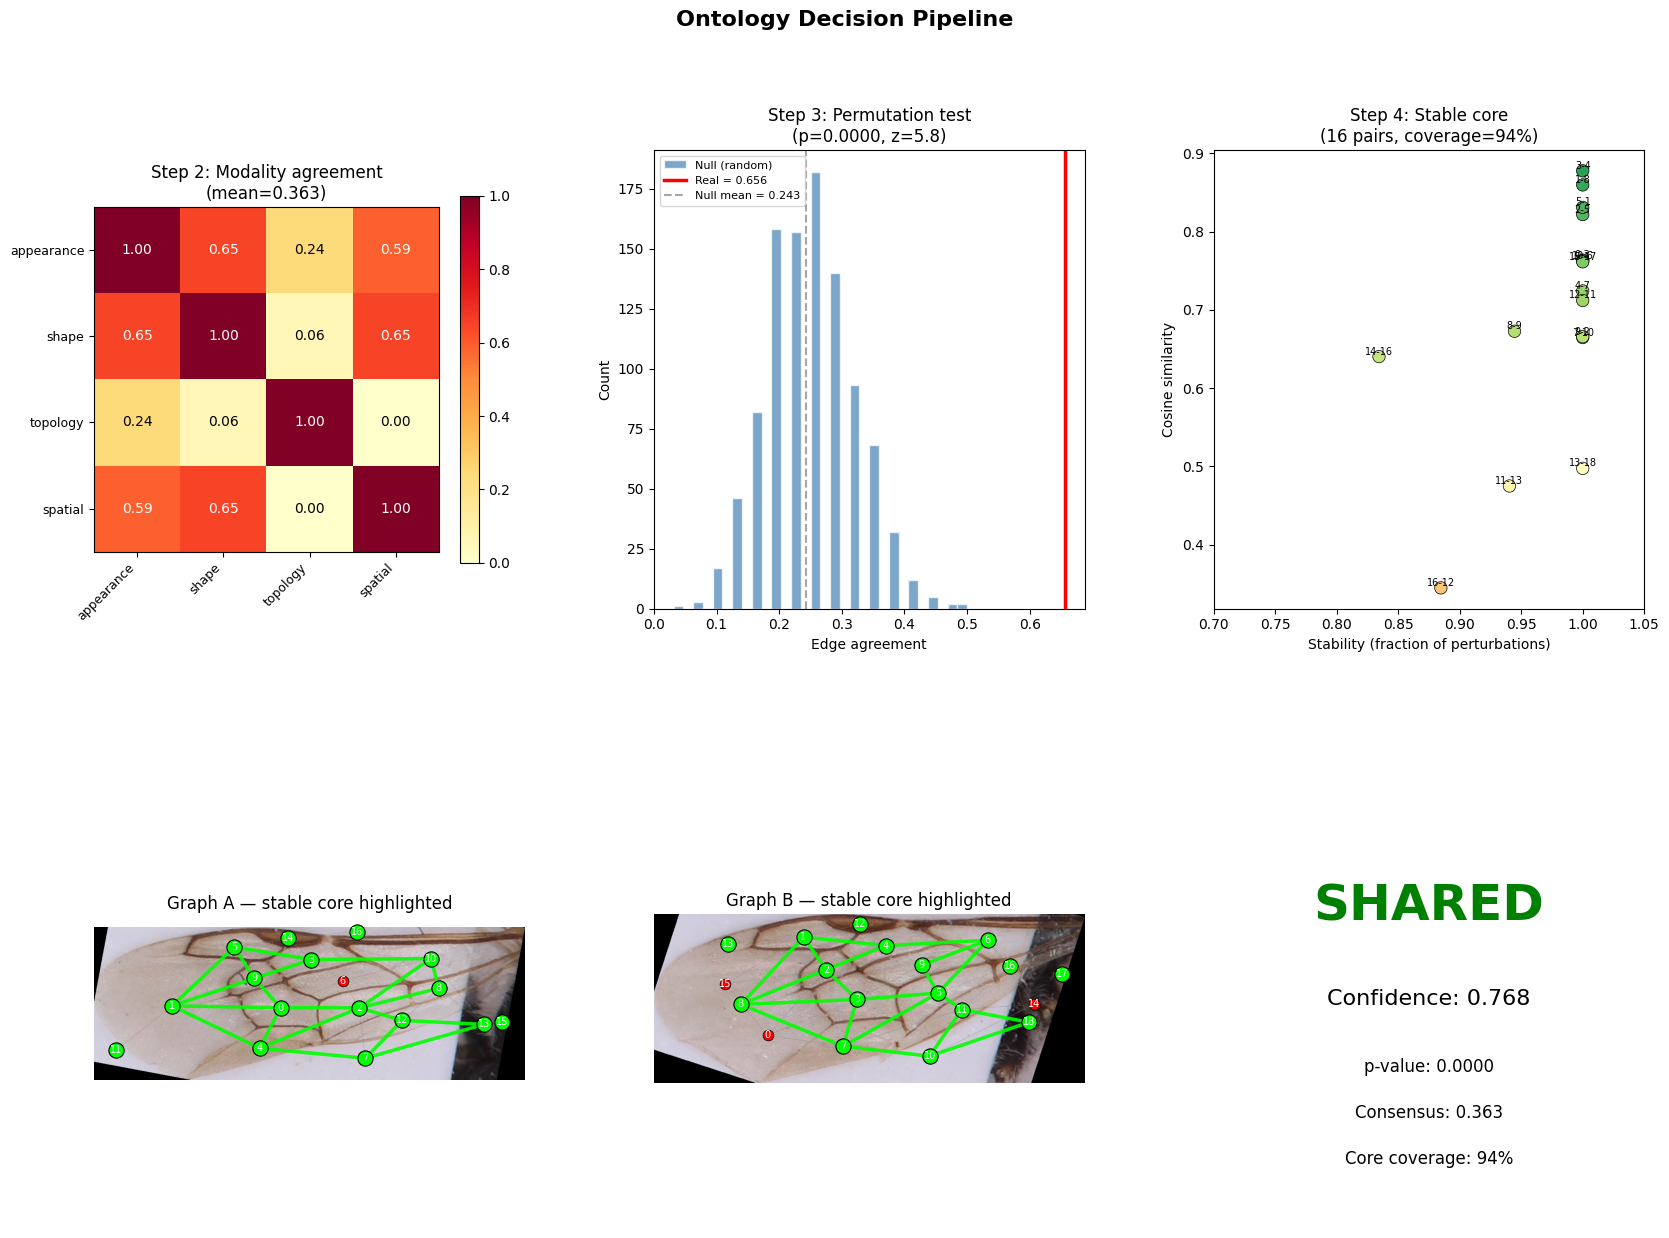

In [95]:
def plot_pipeline_results(results, G_A, G_B, img_A, img_B):
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

    # --- 1. Modality agreement matrix ---
    ax = fig.add_subplot(gs[0, 0])
    m = results['matching']
    im = ax.imshow(m['agreement_matrix'], cmap='YlOrRd', vmin=0, vmax=1)
    ax.set_xticks(range(len(m['modality_names'])))
    ax.set_yticks(range(len(m['modality_names'])))
    ax.set_xticklabels(m['modality_names'], rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(m['modality_names'], fontsize=9)
    for i in range(len(m['modality_names'])):
        for j in range(len(m['modality_names'])):
            ax.text(j, i, f"{m['agreement_matrix'][i,j]:.2f}",
                    ha='center', va='center', fontsize=10,
                    color='white' if m['agreement_matrix'][i,j] > 0.5 else 'black')
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f"Step 2: Modality agreement\n(mean={m['mean_agreement']:.3f})")

    # --- 2. Permutation test ---
    ax = fig.add_subplot(gs[0, 1])
    p = results['permutation']
    ax.hist(p['null_distribution'], bins=30, alpha=0.7, color='steelblue',
            edgecolor='white', label='Null (random)')
    ax.axvline(p['real_agreement'], color='red', linewidth=2.5,
               label=f"Real = {p['real_agreement']:.3f}")
    ax.axvline(p['null_mean'], color='gray', linestyle='--', alpha=0.7,
               label=f"Null mean = {p['null_mean']:.3f}")
    ax.set_xlabel('Edge agreement')
    ax.set_ylabel('Count')
    ax.set_title(f"Step 3: Permutation test\n(p={p['p_value']:.4f}, z={p['z_score']:.1f})")
    ax.legend(fontsize=8)

    # --- 3. Stable core: stability vs similarity ---
    ax = fig.add_subplot(gs[0, 2])
    core = results['core']
    if core['pairs']:
        stabs = [p['stability'] for p in core['pairs']]
        sims = [p['similarity'] for p in core['pairs']]
        labels = [f"{p['node_A']}-{p['node_B']}" for p in core['pairs']]
        colors = plt.cm.RdYlGn(sims)
        ax.scatter(stabs, sims, c=colors, s=80, edgecolors='black', linewidths=0.5)
        for lbl, st, si in zip(labels, stabs, sims):
            ax.annotate(lbl, (st, si), fontsize=7, ha='center', va='bottom')
    ax.set_xlabel('Stability (fraction of perturbations)')
    ax.set_ylabel('Cosine similarity')
    ax.set_title(f"Step 4: Stable core\n({core['n_stable']} pairs, "
                 f"coverage={core['coverage']:.0%})")
    ax.set_xlim(0.7, 1.05)

    # --- 4 & 5. Spatial overlay with stable core highlighted ---
    core_map = core['stable_matching']
    core_edge_set_A = set()
    core_edge_set_B = set()
    for uA, vA, uB, vB in core['core_edges']:
        core_edge_set_A.add((uA, vA))
        core_edge_set_A.add((vA, uA))
        core_edge_set_B.add((uB, vB))
        core_edge_set_B.add((vB, uB))

    for gidx, (G, img, title, core_nodes, core_es) in enumerate([
        (G_A, img_A, "Graph A — stable core highlighted",
         set(core_map.keys()), core_edge_set_A),
        (G_B, img_B, "Graph B — stable core highlighted",
         set(core_map.values()), core_edge_set_B),
    ]):
        ax = fig.add_subplot(gs[1, gidx])
        ax.imshow(img)
        pos = {n: (G.nodes[n]['centroid_x'], G.nodes[n]['centroid_y'])
               for n in G.nodes}

        # Draw non-core edges thin and gray
        non_core = [(u, v) for u, v in G.edges()
                    if (u, v) not in core_es and (v, u) not in core_es]
        nx.draw_networkx_edges(G, pos, edgelist=non_core, ax=ax,
                               width=0.5, alpha=0.3, edge_color='gray')
        # Draw core edges thick and green
        core_el = [(u, v) for u, v in G.edges()
                   if (u, v) in core_es or (v, u) in core_es]
        nx.draw_networkx_edges(G, pos, edgelist=core_el, ax=ax,
                               width=2.5, alpha=0.9, edge_color='lime')

        # Draw nodes: core = green, non-core = red
        core_n = [n for n in G.nodes if n in core_nodes]
        other_n = [n for n in G.nodes if n not in core_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=core_n, ax=ax,
                               node_size=120, node_color='lime',
                               edgecolors='black', linewidths=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=other_n, ax=ax,
                               node_size=60, node_color='red',
                               edgecolors='black', linewidths=0.5)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=7, font_color='white')
        ax.set_title(title)
        ax.axis('off')

    # --- 6. Decision summary ---
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    decision = results['decision']
    conf = results['confidence']
    color = 'green' if decision == 'SHARED' else 'red'
    ax.text(0.5, 0.7, decision, fontsize=36, fontweight='bold',
            ha='center', va='center', color=color,
            transform=ax.transAxes)
    ax.text(0.5, 0.50, f"Confidence: {conf:.3f}", fontsize=16,
            ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0.35, f"p-value: {results['permutation']['p_value']:.4f}",
            fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0.25, f"Consensus: {results['matching']['mean_agreement']:.3f}",
            fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.text(0.5, 0.15, f"Core coverage: {results['core']['coverage']:.0%}",
            fontsize=12, ha='center', va='center', transform=ax.transAxes)

    plt.suptitle("Ontology Decision Pipeline", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_pipeline_results(results, G_left, G_right, image1_np, image2_np)

## Reading the Results

### Step 1 output
- **node ratio = 1.12**: The two graphs have 17 and 19 nodes — very similar sizes (ratio close to 1.0). PASS.
- **degree L1 = 0.830**: The degree distributions differ moderately but within tolerance. PASS.
- **density ratio = 1.02**: Nearly identical graph densities. PASS.

### Step 2 output — Agreement matrix
Each cell shows the fraction of nodes that two modalities matched to the **same** partner:
- **Appearance ↔ Shape (0.65)**: 65% of the time, the node that *looks* most similar (DINOv2) is also the one that *measures* most similar (area, circularity, etc.). Strong convergence.
- **Appearance ↔ Spatial (0.59)**: Parts that look alike also sit in similar relative positions in the wing. Consistent with bilateral symmetry.
- **Shape ↔ Spatial (0.65)**: Similarly-shaped cells occupy similar positions. Strong.
- **Topology ↔ everything (0.00–0.24)**: Topology features (degree, clustering coeff, betweenness) are too coarse — many nodes look the same topologically, so Hungarian matching based on topology alone is ambiguous. This is expected and doesn't invalidate the result.

**Mean agreement = 0.363**: Averaged across all 6 pairs of modalities. Above the 0.25 threshold → the matches aren't coincidental.

### Step 3 output — Permutation test
- **Real edge agreement = 0.656**: Under the optimal matching, 65.6% of adjacency relationships in graph A are preserved in graph B.
- **Null mean = 0.239 ± 0.070**: Random matchings preserve only ~24% of edges on average.
- **z-score = 5.98**: The real score is **6 standard deviations** above the null — extremely unlikely by chance.
- **p-value = 0.000**: Zero out of 1000 random permutations achieved the real score.

*Interpretation: The edge structure is overwhelmingly conserved. This cannot happen by accident.*

### Step 4 output — Stable core
- **16 stable pairs (94.1% coverage)**: Out of 17 nodes in graph A, 16 have a partner in graph B that survives across perturbations. Only 1 node lacks a stable match.
- **12 pairs with stability = 1.00**: These were matched identically in every single perturbation — rock-solid correspondences.
- **20 core edges**: Adjacency relationships that exist in both graphs under the stable matching. This is the discovered shared wiring diagram.
- **Weakest pair (A:16↔B:12)**: stability=0.87, similarity=0.345 — still stable but the visual resemblance is low, possibly a segment that SAM handled differently between images.

### Final decision
- **SHARED** with confidence **0.768**, composed of:
  - `1 − p_value = 1.000` — permutation test is conclusive
  - `mean_agreement = 0.363` — moderate but sufficient cross-modality consensus
  - `core_coverage = 0.941` — nearly all structure is stably matched

The confidence would be higher if the topology modality agreed better with the others, but two out of three signals are very strong.